In [1]:
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt

In [2]:
import random
random.seed(1)
# base station location
base_X = 25
base_Y = -100
# transmission energy and receive energy J/bit
ETx = 50*0.000000001
ERc = ETx
# amplification coefficientds J/bit/m^2
epsilon_amp = 10*0.000000000001
# number of clusters
num_clusters = 5
# number of nodes
num_nodes = 100
# initial energy of one node
energy = 2
# size of a packet
packet_bit = 20000
# aggregation energy
aggr = 5*0.000000001
# gather x bits together and aggregate them into 0.3 * x bits
aggr_rate = 0.25
# P and 1/P calculating threshould
P = num_clusters / (num_nodes * 1.0)
one_by_P = num_nodes // num_clusters

In [3]:
# cluster class
class Cluster:
    def __init__(self):
        # nodes in one cluster
        self.nodes = []
        # cluster head, type (node)
        self.head = None
        # number of bits awaiting aggregation
        self.bits = 0
    
    # add one node into the cluster
    def add(self, node):
        self.nodes.append(node)
      
    # tell whether the node is the cluster head
    def is_head(self, node):
        return node == self.head
    
    # quick calculation of the square of distance between one node and the cluster head
    def dis(self, node):
        return distance(node.X, self.head.X, node.Y, self.head.Y)

In [4]:
# square of distance instead of distance
def distance(x_1, x_2, y_1, y_2):
    return (x_1 - x_2)**2 + (y_1 - y_2)**2

In [5]:
def T(r):
    #print(P, one_by_P, r, P / (1 - P * (r % one_by_P)))
    return P / (1 - P * (r % one_by_P))

In [6]:
import random

class Node:
    def __init__(self, x, y):
        # (X,Y)
        self.X = x
        self.Y = y
        # remaining energy
        self.energy = energy
        # false means the nodes alive, otherwise dead
        self.die = False
        self.last = -1
        self.cluster = None
    
    def elect(self, r, clusters):
        self.cluster = None
        if r % one_by_P == 0:
            self.last = -1
        if (self.last == -1 or self.last + one_by_P <= r % one_by_P) and not self.die:
            if random.uniform (0,1) <= T(r):
                cluster = Cluster()
                cluster.add(self)
                cluster.head = self
                clusters.append(cluster)
                self.last = r
                self.cluster = cluster
                #print(r, len(clusters))
    
    def select(self, r, clusters):
        if self.cluster != None:
            return
        min_dis = 100000000
        cluster = -1
        for i in range(len(clusters)):
            if min_dis > clusters[i].dis(self):
                cluster = i
                min_dis = clusters[i].dis(self)
        #print(len(clusters), cluster)
        if cluster == -1:
            return
        clusters[cluster].add(self)
        self.cluster = clusters[cluster]
    
    def direct(self):
        transmission = ETx * packet_bit
        amplification = epsilon_amp * packet_bit * distance(self.X, base_X, self.Y, base_Y)
        if self.energy < transmission + amplification:
            self.die = True
        else:
            self.energy -= (transmission + amplification)
    
    def send(self):
        if self.cluster.is_head(self):
            if self.cluster.bits == 0:
                transmission = ETx * packet_bit
                amplification = epsilon_amp * packet_bit * distance(self.X, base_X, self.Y, base_Y)
                if self.energy < transmission + amplification:
                    self.die = True
                else:
                    self.energy -= (transmission + amplification)
            else:
                transmission = ETx * aggr_rate * (packet_bit + self.cluster.bits)
                amplification = epsilon_amp * aggr_rate * (packet_bit + self.cluster.bits) * distance(self.X, base_X, self.Y, base_Y)
                if self.energy < transmission + amplification + aggr:
                    self.die = True
                else:
                    self.energy -= (transmission + amplification + aggr)
        else:
            if self.cluster.head.die:
                self.die = True
                return
            transmission = ETx * packet_bit
            amplification = epsilon_amp * packet_bit * self.cluster.dis(self)
            if self.energy < transmission + amplification:
                self.die = True
            else:
                self.energy -= (transmission + amplification)
            receive = ERc * packet_bit
            self.cluster.head.energy -= receive
            self.cluster.bits += packet_bit

In [7]:
num_nodes = 200
Xs = uniform.rvs(loc=0, scale=60, size=num_nodes)
Ys = uniform.rvs(loc=0, scale=60, size=num_nodes)

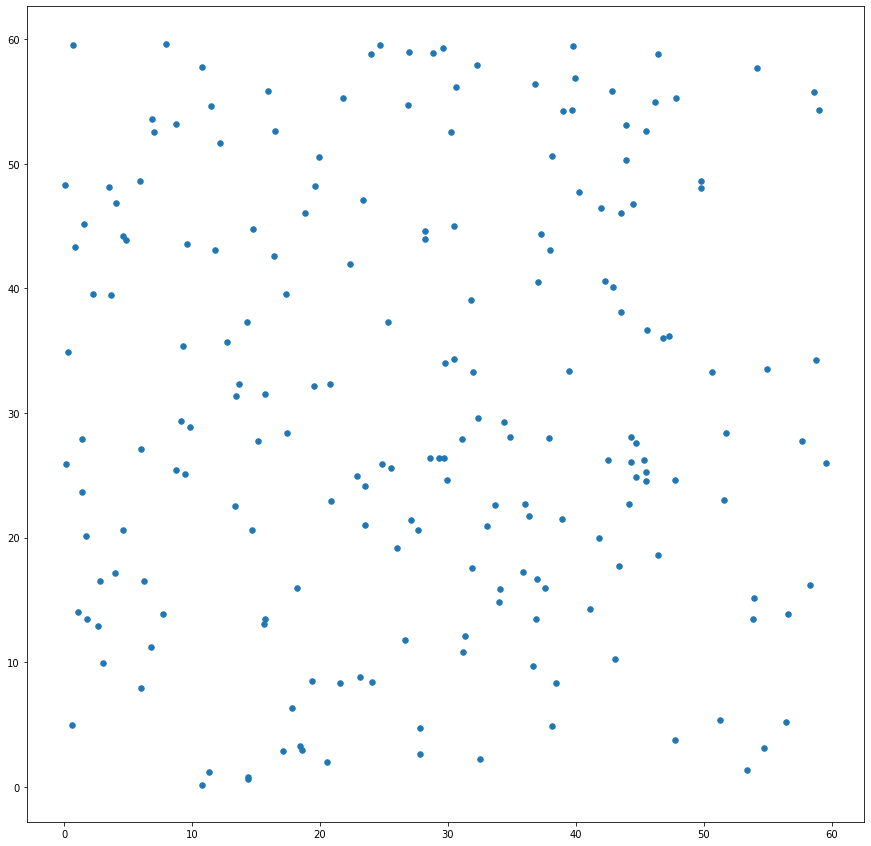

In [8]:
plt.figure(figsize=(15, 15))
plt.scatter(Xs, Ys, s = 30)

In [9]:
# 2 ---> 4
# 1 ---> 4
# 0.5 ---> 4
# 0.25 ---> 2
# 0.125 ---> 2
# 4 ----> 4

0 number of nodes dead 0
400 number of nodes dead 0
800 number of nodes dead 0
1200 number of nodes dead 0
1600 number of nodes dead 47
2000 number of nodes dead 173
2400 number of nodes dead 199
0 number of nodes dead 0
400 number of nodes dead 0
800 number of nodes dead 0
1200 number of nodes dead 0
1600 number of nodes dead 50
2000 number of nodes dead 153
2400 number of nodes dead 194
0 number of nodes dead 0
400 number of nodes dead 0
800 number of nodes dead 0
1200 number of nodes dead 0
1600 number of nodes dead 36
2000 number of nodes dead 166
2400 number of nodes dead 198
0 number of nodes dead 0
400 number of nodes dead 0
800 number of nodes dead 0
1200 number of nodes dead 0
1600 number of nodes dead 43
2000 number of nodes dead 148
2400 number of nodes dead 192
0 number of nodes dead 0
400 number of nodes dead 0
800 number of nodes dead 0
1200 number of nodes dead 0
1600 number of nodes dead 46
2000 number of nodes dead 154
2400 number of nodes dead 197


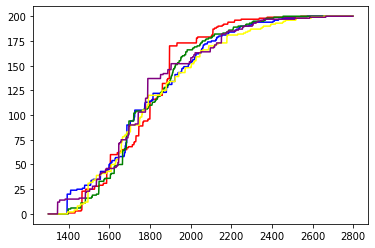

In [18]:
packet_bit = 2000
energy = 0.5
num_rounds = 2800
random.seed(1)
color = ['red', 'blue', 'green', 'yellow', 'purple']
index = -1
for k in [1, 1.25, 1.5, 2, 4]:
    index += 1
    Nodes = [Node(Xs[i], Ys[i]) for i in range(num_nodes)]
    clusters = []
    dead = []
    num = []
    P = 0.05
    one_by_P = 1/P
    for i in range(num_rounds):
        if i%400 == 0:
            print(i, "number of nodes dead", len(dead))
        num.append(len(dead))
        #print("energy", Nodes[0].energy)
        clusters = []
        for node in Nodes:
            node.elect(i, clusters)
        if len(clusters) == 0:
            #print(i, "PPPPPPPPPP", P, T(i))
            #P = 5/(num_nodes - len(dead) + 1)
            P *= k
            P = min(1, P)
            one_by_P = 1/P
            for j in range(num_nodes):
                if j not in dead:
                    Nodes[j].direct()
                    if Nodes[j].die:
                        dead.append(j)
        else:
            for node in Nodes:
                node.select(i, clusters)
            for j in range(num_nodes):
                if j not in dead:
                    Nodes[j].send()
                    if Nodes[j].die:
                        dead.append(j)

    plt.plot(range(num_rounds)[1300:], num[1300:], color = color[index])

0 number of nodes dead 0
400 number of nodes dead 0
800 number of nodes dead 0
1200 number of nodes dead 0
1600 number of nodes dead 48
2000 number of nodes dead 163
2400 number of nodes dead 197


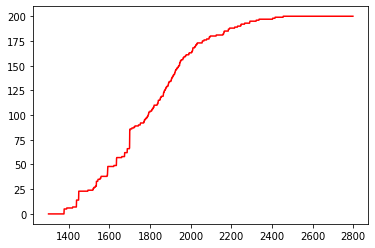

In [35]:
Nodes = [Node(Xs[i], Ys[i]) for i in range(num_nodes)]
clusters = []
dead = []
num = []
P = 0.05
one_by_P = 1/P
for i in range(num_rounds):
    if i%400 == 0:
        print(i, "number of nodes dead", len(dead))
    num.append(len(dead))
    #print("energy", Nodes[0].energy)
    clusters = []
    for node in Nodes:
        node.elect(i, clusters)
    if len(clusters) == 0:
        P *= (1 + max((len(dead) - 0.3 * num_nodes), 0) / num_nodes)
        #P = 5 / ((num_nodes) - len(dead) + 1)
        P = min(1, P)
        one_by_P = 1/P
        for j in range(num_nodes):
            if j not in dead:
                Nodes[j].direct()
                if Nodes[j].die:
                    dead.append(j)
    else:
        for node in Nodes:
            node.select(i, clusters)
        for j in range(num_nodes):
            if j not in dead:
                Nodes[j].send()
                if Nodes[j].die:
                    dead.append(j)

plt.plot(range(num_rounds)[1300:], num[1300:], color = "red")

In [31]:
random.seed(1)
Nodes = [Node(Xs[i], Ys[i]) for i in range(num_nodes)]
clusters = []
dead = []
num1 = []
P = 0.05
one_by_P = 1/P
for i in range(num_rounds):
    if i%400 == 0:
        print(i, "number of nodes dead", len(dead))
    num1.append(len(dead))
    #print("energy", Nodes[0].energy)
    clusters = []
    for node in Nodes:
        node.elect(i, clusters)
    if len(clusters) == 0:
        for j in range(num_nodes):
            if j not in dead:
                Nodes[j].direct()
                if Nodes[j].die:
                    dead.append(j)
    else:
        for node in Nodes:
            node.select(i, clusters)
        for j in range(num_nodes):
            if j not in dead:
                Nodes[j].send()
                if Nodes[j].die:
                    dead.append(j)


0 number of nodes dead 0
400 number of nodes dead 0
800 number of nodes dead 0
1200 number of nodes dead 0
1600 number of nodes dead 47
2000 number of nodes dead 173
2400 number of nodes dead 199


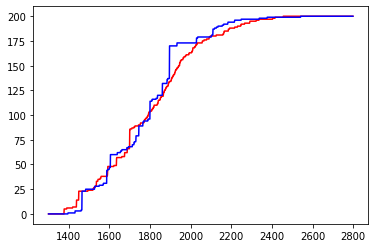

In [36]:
plt.plot(range(num_rounds)[1300:], num[1300:], color = "red")
plt.plot(range(num_rounds)[1300:], num1[1300:], color = "blue")

0 number of nodes dead 0
10 number of nodes dead 0
20 number of nodes dead 0
30 number of nodes dead 0
40 number of nodes dead 0
50 number of nodes dead 0
60 number of nodes dead 0
70 number of nodes dead 0
80 number of nodes dead 0
90 number of nodes dead 0
100 number of nodes dead 24
110 number of nodes dead 42
120 number of nodes dead 57
130 number of nodes dead 70
140 number of nodes dead 79
150 number of nodes dead 84
160 number of nodes dead 97
170 number of nodes dead 100
180 number of nodes dead 100
190 number of nodes dead 100
200 number of nodes dead 100
210 number of nodes dead 100
220 number of nodes dead 100
230 number of nodes dead 100
240 number of nodes dead 100


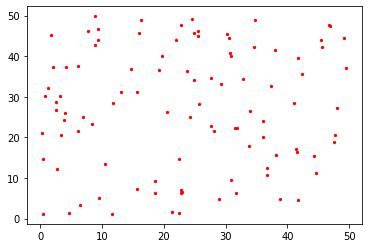

In [13]:
Nodes = [None for i in range(num_nodes)]

for i in range(num_nodes):
    Nodes[i] = Node(Xs[i], Ys[i])
num2 = []
dead = []
for i in range(250):
    num2.append(len(dead))
    if i%10 == 0:
        print(i, "number of nodes dead", len(dead))
    #print(Nodes[0].energy)
    for j in range(num_nodes):
        if j not in dead:
            Nodes[j].direct()
            if Nodes[j].die:
                dead.append(j)
                
dead_X = []
dead_Y = []
undead_X = []
undead_Y = []
for i in range(num_nodes):
    if i in dead:
        dead_X.append(Xs[i])
        dead_Y.append(Ys[i])
    else:
        undead_X.append(Xs[i])
        undead_Y.append(Ys[i])
plt.scatter(dead_X, dead_Y, s = 5, color = 'red')
plt.scatter(undead_X, undead_Y, s = 5, color = 'blue')

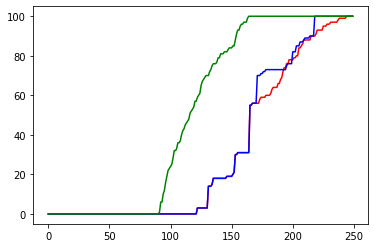

In [34]:
plt.plot(range(250), num, color = 'r')
plt.plot(range(250), num1, color = 'b')
plt.plot(range(250), num2, color = 'g')